# Прогнозирование газового фактора
Источники данных: ШТР  
Гипотезы:  
1. При снижении забойного давления происходит увеличение газового фактора. 
2. Газовый фактор зависит от пластового давления

# Для воспроизведения результатов кейса с данными ШТР необходимо получить доступ к СИД
инструкция: https://kb.gazprom-neft.local/pages/viewpage.action?pageId=29138716
# Описание используемых параметров:  
gas_factor - газовый фактор  
lfp_intake - забойное давление  
layer_shut_pressure - пластовое давление  

# Библиотеки

In [12]:
#установка необходимых библиотек
#раскомментировать при первом запуске
# !pip install python-dotenv
# !pip install psycopg2-binary
# !pip install matplotlib
# !pip install sqlalchemy
# !pip install pandas-profiling
# !pip install nltk
# !pip install scikit-learn
# !pip install seaborn

In [13]:
#импорт библиотек
import psycopg2 
import psycopg2.extras
import pandas as pd
import os
import random
from matplotlib import pyplot as plt
from dotenv import load_dotenv
import numpy as np
from sqlalchemy import create_engine
#import pandas_profiling
import seaborn as sns
import nltk
import sklearn
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
import scipy.stats as stats

# Переменные окружения 
Для безопасного хранения учетных данных при подключения к КЛАД рекомендуется использовать переменные окружения.  
Вводить пароль в явном виде в строке подключения небезопасно.  
Подробно о создании переменных окружения написано здесь: https://kb.gazprom-neft.local/pages/viewpage.action?pageId=167968943

In [14]:
#загрузка переменных окружения для подключения к БД
load_dotenv()

True

In [15]:
#получение переменных
USER = os.environ.get('USER')
PASSWORD = os.environ.get('PASSWORD')
HOST = 'spb99akl-adbm01' 
DB = 'edw'

In [16]:
#формирование строки подключения к БД
conn_string = psycopg2.connect(f"dbname={DB} user='{USER}' host={HOST} password='{PASSWORD}'")

In [17]:
#открытие курсора
cursor = conn_string.cursor()

In [18]:
#проверка подключения
cursor.execute("SELECT version();")
record = cursor.fetchone()
print(f"Подключение к {record} выполнено")

Подключение к ('PostgreSQL 9.4.26 (Greenplum Database 6.22.0 build 6.22.0_arenadata38-1056.git4bb37f3) on x86_64-unknown-linux-gnu, compiled by x86_64-alt-linux-gcc (GCC) 8.4.1 20200305 (ALT p9 8.4.1-alt0.p9.1), 64-bit compiled on Oct 19 2022 16:43:31',) выполнено


# Чтение данных ШТР

In [19]:
#запрос данных c ограничением по ДО и дате замера
#если при выполнении запроса перезапускается ядро, установите более жесткое ограничение для уменьшения выборки
DO = 'Заполяр'
DATE = '2022-06-01'
query = f"select d.well_id, calc_date, layer_id, layer_count, layer_names, confirmed, is_efficient, priority, non_stable, start_after_repair, start_date, stop_date, status_id, periodicity_time, periodicity_work_time, prod_method_id, pump_type_id, pump_install_date,pump_depth, plunger_diameter, plunger_stroke_length, pump_freq, rocking_count, pump_output, pump_head, rocker_type_id, choke_diameter, paker_type_id, paker_install_date, paker_depth, casing_diameter, tubing_diameter, d.is_horizontal, dyn_level, dyn_level_est_method_id, static_level, casing_pressure, manual_casing_pressure, buffer_pressure, manual_buffer_pressure, inline_pressure, manual_inline_pressure, intake_pressure, act_time, pek, liq_rate_est_method_id, water_cut_est_method_id, motor_type_id, motor_power, pump_current, static_casing_pressure, cause_stop, squeeze_date, dyn_level_sq, casing_pressure_sq, pump_current_nom, pump_depth_max, extra_equip, extra_equip_diam, extra_equip_depth, gas_separator_id, nest, pump_flowing, liq_rate, water_cut, oil_rate, manual_layer_shut_pressure, layer_shut_pressure, layer_flow_pressure, liquid, oil, liquid_viscosity, oil_compressibility, bubble_point_pressure, gas_factor, oil_density, water_density, perf_depth, perf_depth_delta, perf_thickness, saturated_thickness, contour_radius, layer_flow_pressure_calc, skin, frac_date, contractor, skin_calc, pi, pi_fixed, kh, kh_fixed, jd, jd_opt, liq_rate_tp, liq_rate_tp_corr, oil_rate_tp, pi_tp_skin, liq_rate_tp_skin, liq_rate_tp_skin_corr, oil_rate_tp_skin, stab_time, remarks, temperature, separation_factor, target_layer_flow_pressure, water_viscosity, oil_viscosity, layer_shut_pressure_date, is_well_row, water_percent, oil_percent, liq_rate_tp_tech, liq_rate_tp_corr_tech, oil_rate_tp_tech, liq_rate_tp_skin_tech, liq_rate_tp_skin_corr_tech, oil_rate_tp_skin_tech, target_lfp_tech, init_shut_pressure, dyn_level_delta, pump_depth_delta, number1, number2, number3, number4, number5, number6, number7, number8, number9, date1, date2, date3, string1, string2, string3, updated, lfp_hd, lfp_intake, start_liq_rate, start_water_cut, start_oil_rate, energy_intensity, work_layers, layers_perf_depths, pump_name, comments, last_gtm_prev_1y, last_gtm_prev_2y, all_casing, deviation_reason_id, watering_hal, liquid_rate_tm, liquid_rate_shady, standstill_time, watering_shady, oil_rate_shady, k_dec, pg_rate, pg_rate_shady, vdp_pressure, vdp_pressure_date, geo_k_gidr, geo_k_prod, geo_k_pr, geo_measure_date, gas_rate_tm, triz_is, triz_control, d.bottom_depth,d.dns_id, d.dome_id, d.field_id, d.gsu_id, d.kns_id, d.non_balance, d.org_id, d.rig_no, d.shop_id, d.well_cluster, d.project_purpose_name, d.rig_lit, d.team_no, d.site_id, d.gsu_name, d.site_name, d.shop_name, d.dome_name, d.org_name, d.field_name, d.field_code, mrp, d.gsu_type, d.gsu_rate_metering_method, f.well_name, f.bore_dir_type from ods_shtr_wellop.well_op_oil_daily d left join ods_shtr_wellop.v_well_full f on d.well_id = f.well_id where d.org_name like '%{DO}%' and calc_date > '{DATE}' ;"
data = pd.read_sql(query, con=conn_string)

In [20]:
#вывод первых строк
data.head()

,well_id,calc_date,layer_id,layer_count,layer_names,confirmed,is_efficient,priority,non_stable,start_after_repair,...,shop_name,dome_name,org_name,field_name,field_code,mrp,gsu_type,gsu_rate_metering_method,well_name,bore_dir_type
0,5.020120e+09,2022-06-05,PL0077,1.0,None,0.0,1.0,None,None,2021-08-06 02:01:00,...,Нефтяные оторочки,0,"ООО ""Газпромнефть - Заполяр",Западно-Таркосалинское,502.0,424.0,Массомер (жидкость),None,1204,Горизонтальный
1,5.020121e+09,2022-06-05,PL0077,1.0,None,0.0,1.0,None,None,2022-04-15 02:01:00,...,Нефтяные оторочки,0,"ООО ""Газпромнефть - Заполяр",Западно-Таркосалинское,502.0,243.0,None,None,1206,Горизонтальный
2,5.020121e+09,2022-06-05,PL0077,1.0,None,0.0,1.0,None,None,2021-08-06 02:01:00,...,Нефтяные оторочки,0,"ООО ""Газпромнефть - Заполяр",Западно-Таркосалинское,502.0,424.0,Массомер (жидкость),None,1207,Горизонтальный
3,5.020120e+09,2022-06-04,PL0077,1.0,None,0.0,1.0,None,None,2021-08-06 02:01:00,...,Нефтяные оторочки,0,"ООО ""Газпромнефть - Заполяр",Западно-Таркосалинское,502.0,424.0,Массомер (жидкость),None,1204,Горизонтальный
4,5.020121e+09,2022-06-04,PL0077,1.0,None,0.0,1.0,None,None,2022-04-15 02:01:00,...,Нефтяные оторочки,0,"ООО ""Газпромнефть - Заполяр",Западно-Таркосалинское,502.0,243.0,None,None,1206,Горизонтальный


In [21]:
#получение общей информаци о датасете
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30456 entries, 0 to 30455
Columns: 196 entries, well_id to bore_dir_type
dtypes: datetime64[ns](11), float64(110), object(75)
memory usage: 45.5+ MB


In [22]:
#описательные статистики параметров
data[['gas_factor','lfp_intake','layer_shut_pressure']].describe()

,gas_factor,lfp_intake,layer_shut_pressure
count,29142.000000,18668.000000,29712.000000
mean,1273.952244,127.313619,210.027275
std,2385.656271,31.255389,107.243384
min,9.437334,30.107882,80.000000
25%,340.537768,112.452840,126.410000
50%,829.327760,118.879838,197.100000
75%,1564.034037,143.070858,240.095000
max,308679.012346,366.932265,622.000000


In [23]:
print(f'В датасете ГПН-Заполярья {data.shape[0]} строк со {data.shape[1]} параметрами по {len(data["well_name"].unique())} уникальным скважинам за период с {data["calc_date"].min()} по {data["calc_date"].max()}')

В датасете ГПН-Заполярья 30456 строк со 196 параметрами по 148 уникальным скважинам за период с 2022-06-02 00:00:00 по 2023-01-17 00:00:00


# Визуальная оценка данных

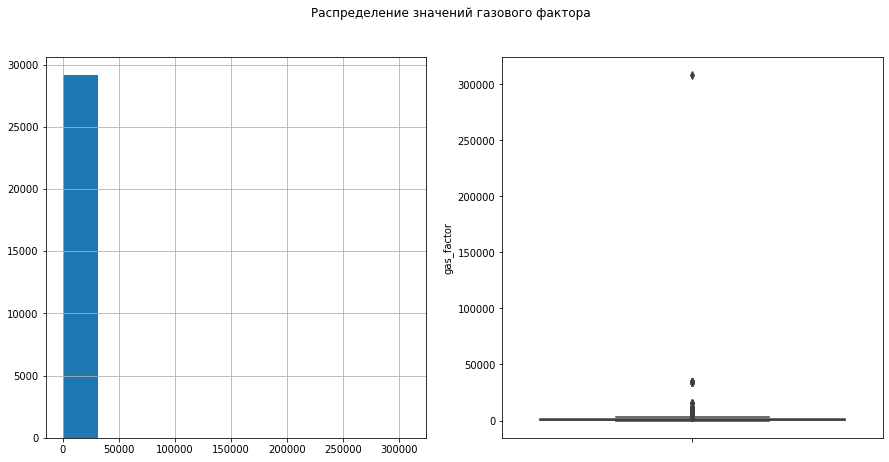

In [24]:
#строим гистрограмму и ящик с усами для анализа распределения и наличия выбросов значений газового фактора
fig, axes = plt.subplots(1, 2, squeeze=False, figsize=(15, 7))
data['gas_factor'].hist(ax=axes[0, 0])
sns.boxplot(y='gas_factor', data=data, ax=axes[0, 1])
plt.suptitle('Распределение значений газового фактора');

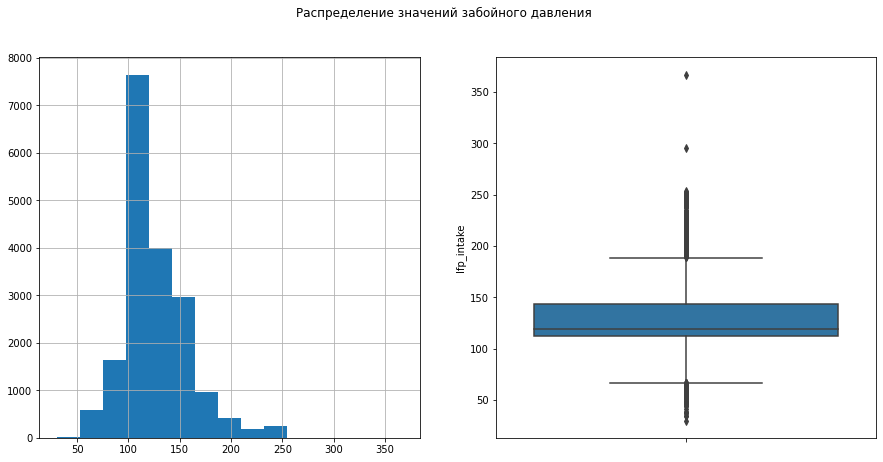

In [25]:
#аналогично по забойному давлению
fig, axes = plt.subplots(1, 2, squeeze=False, figsize=(15, 7))
data['lfp_intake'].hist(bins=15, ax=axes[0, 0])
sns.boxplot(y='lfp_intake', data=data, ax=axes[0, 1])
plt.suptitle('Распределение значений забойного давления');

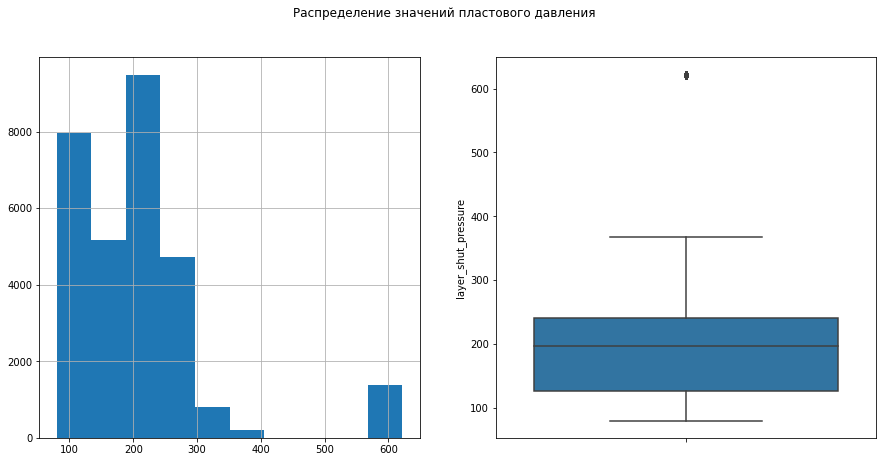

In [26]:
#аналогично по пластовому давлению
fig, axes = plt.subplots(1, 2, squeeze=False, figsize=(15, 7))
data['layer_shut_pressure'].hist(bins=10, ax=axes[0, 0])
sns.boxplot(y='layer_shut_pressure', data=data, ax=axes[0, 1])
plt.suptitle('Распределение значений пластового давления');

Делаем вывод, что во всех значениях есть выбросы (аномальные значения), от которых необходимо избавиться.  
Также видим, что распределения не похожи на нормальные, что важно для выбора статистических методов анализа далее.

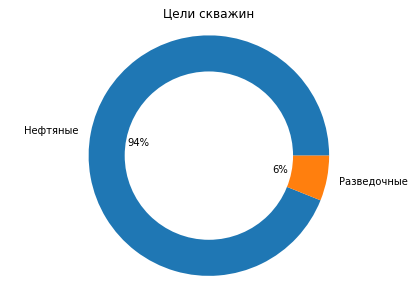

In [27]:
#визуализируем категориальные параметры для наглядности
#по цели скважины
purpose = data['project_purpose_name'].value_counts()

fig, ax = plt.subplots()

ax.pie(x = purpose.values, labels = purpose.keys(), autopct='%.0f%%')
centre_circle = plt.Circle((0,0),0.70,fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)

ax.axis('equal')  
plt.tight_layout()
plt.title("Цели скважин")

plt.show()

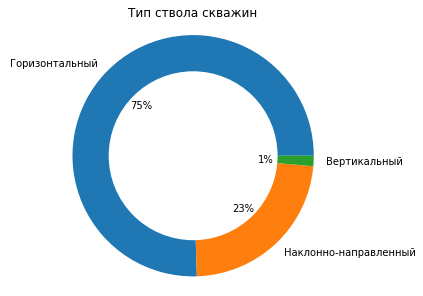

In [28]:
#по типу ствола
purpose = data['bore_dir_type'].value_counts()

fig, ax = plt.subplots()

ax.pie(x = purpose.values, labels = purpose.keys(),  autopct='%.0f%%')
centre_circle = plt.Circle((0,0),0.70,fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)

ax.axis('equal')  
plt.tight_layout()
plt.title("Тип ствола скважин")
plt.show()

Делаем вывод, что в фонде преобладают горизонтальные нефтяные скважины.

# Очистка данных

In [29]:
#устанавливаем индексацию по дате и сортируем датафрейм
data.set_index('calc_date',inplace=True)
data.sort_index(inplace=True)

In [30]:
#после чего можем применять такие срезы
data['2022-11':'2022-12']

,well_id,layer_id,layer_count,layer_names,confirmed,is_efficient,priority,non_stable,start_after_repair,start_date,...,shop_name,dome_name,org_name,field_name,field_code,mrp,gsu_type,gsu_rate_metering_method,well_name,bore_dir_type
calc_date,,,,,,,,,,,,,,,,,,,,,
2022-11-01,8.550107e+09,PL0900,1.0,None,0.0,1.0,None,None,2021-08-22 02:02:00,2021-08-22 02:00:00,...,Чаяндинское НГКМ,0,"ООО ""Газпромнефть - Заполяр",Чаяндинское,855.0,466.0,Массомер (жидкость),None,1066,Горизонтальный
2022-11-01,8.920927e+09,PL3499,1.0,None,0.0,1.0,None,None,2022-05-09 11:20:59,2022-05-09 00:00:00,...,Нефтяные оторочки,0,"ООО ""Газпромнефть - Заполяр",Песцовое,892.0,219.0,Массомер (жидкость),None,9266,Горизонтальный
2022-11-01,8.550105e+09,PL0900,1.0,None,0.0,1.0,None,None,2021-10-13 02:01:00,2021-10-13 02:01:00,...,Чаяндинское НГКМ,0,"ООО ""Газпромнефть - Заполяр",Чаяндинское,855.0,425.0,Массомер (жидкость),None,1051,Горизонтальный
2022-11-01,8.920923e+09,PL3499,1.0,None,0.0,1.0,None,None,2022-01-08 10:00:43,2022-01-08 00:00:00,...,Нефтяные оторочки,0,"ООО ""Газпромнефть - Заполяр",Песцовое,892.0,338.0,Массомер (жидкость),None,9227,Горизонтальный
2022-11-01,8.920922e+09,PL3499,1.0,None,0.0,1.0,None,None,2020-07-23 16:00:00,2020-07-23 02:01:00,...,Нефтяные оторочки,0,"ООО ""Газпромнефть - Заполяр",Песцовое,892.0,861.0,Массомер (жидкость),None,9225,Горизонтальный
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-31,8.920927e+09,PL3499,1.0,None,0.0,1.0,None,None,2022-01-26 02:00:01,2022-01-26 02:00:00,...,Нефтяные оторочки,0,"ООО ""Газпромнефть - Заполяр",Песцовое,892.0,341.0,Массомер (жидкость),None,9273,Горизонтальный
2022-12-31,9.200247e+08,PL0182,1.0,None,0.0,1.0,None,None,2021-08-22 02:01:00,2021-08-22 02:01:00,...,Ямбургское НГКМ,0,"ООО ""Газпромнефть - Заполяр",Ямбургское,92.0,106.0,None,None,247,Горизонтальный
2022-12-31,8.920924e+09,PL3499,1.0,None,0.0,1.0,None,None,2022-08-23 10:58:00,2022-08-23 10:58:00,...,Нефтяные оторочки,0,"ООО ""Газпромнефть - Заполяр",Песцовое,892.0,132.0,Массомер (жидкость),None,9241,Горизонтальный


In [31]:
#удаляем столбцы, в которых содержится только одно значение
for column in data.columns:
    res = data[column].value_counts()
    if len(res.keys())<=1:
        data = data.drop(column,axis=1)        

In [32]:
#удаляем строковые столбцы (предварительный вариант, нужно добавить OHE)
for column in data.columns:
    if(data[column].dtypes=='object' and column!='well_name' and column!='bore_dir_type' and column !='project_purpose_name'):
        #print(column)
        #print(data[column].value_counts())
        data = data.drop(column,axis=1)  

# Обработка пропусков и выбросов

In [33]:
#оцениваем, сколько пропусков в данных
data.isna().mean()[:50]

well_id                     0.000000
layer_count                 0.022656
start_after_repair          0.000000
start_date                  0.037661
stop_date                   0.014020
pump_install_date           0.000164
pump_depth                  0.000000
pump_freq                   0.254367
pump_output                 0.262182
pump_head                   0.256501
choke_diameter              0.376084
paker_install_date          0.977344
paker_depth                 0.977344
casing_diameter             0.000000
tubing_diameter             0.019077
is_horizontal               0.000000
dyn_level                   0.063042
casing_pressure             0.057197
buffer_pressure             0.067409
inline_pressure             0.051221
intake_pressure             0.381665
act_time                    0.139907
pek                         0.404255
pump_current                0.254367
pump_depth_max              0.385507
extra_equip_diam            0.534016
extra_equip_depth           0.511361
p

In [34]:
#удаляем все строки с пустым значением целевой переменной
data = data.dropna(subset=['gas_factor'])

In [35]:
#удаляем столбцы, в которых все значений пустые
data = data.dropna(axis=1,how='all')

In [36]:
#проверяем, в каких столбцах еще есть пропущенные значения
data.isna().mean()[:30]

well_id               0.000000
layer_count           0.023677
start_after_repair    0.000000
start_date            0.000000
stop_date             0.014481
pump_install_date     0.000172
pump_depth            0.000000
pump_freq             0.246345
pump_output           0.252556
pump_head             0.246620
choke_diameter        0.354059
paker_install_date    0.976323
paker_depth           0.976323
casing_diameter       0.000000
tubing_diameter       0.000000
is_horizontal         0.000000
dyn_level             0.026285
casing_pressure       0.020108
buffer_pressure       0.030849
inline_pressure       0.012971
intake_pressure       0.359207
act_time              0.106273
pek                   0.386384
pump_current          0.246345
pump_depth_max        0.361300
extra_equip_diam      0.516265
extra_equip_depth     0.492588
pump_flowing          0.000172
liq_rate              0.000034
water_cut             0.000000
dtype: float64

In [37]:
#заполняем пропуски предыдущим/следующим по дате значением признака для каждой скважины
data = data.groupby('well_id').ffill().bfill()

In [38]:
#оставшиеся пропуски заполняем 0
data.fillna(0,inplace=True)

In [39]:
#проверяем, что пустых значений не осталось
data.isna().mean()[:10]

layer_count           0.0
start_after_repair    0.0
start_date            0.0
stop_date             0.0
pump_install_date     0.0
pump_depth            0.0
pump_freq             0.0
pump_output           0.0
pump_head             0.0
choke_diameter        0.0
dtype: float64

In [40]:
#фиксируем 0.99 квантиль значений параметров для избавления от выбросов
gas_factor_99 = data.gas_factor.quantile(0.99)
lfp_intake_99 = data.lfp_intake.quantile(0.99)
layer_shut_pressure_99 = data.layer_shut_pressure.quantile(0.99)
gas_factor_99

6472.31288377496

In [41]:
#оцениваем количество строк с выбросами
data[(data['gas_factor']>gas_factor_99)|(data['lfp_intake']>lfp_intake_99)|(data['layer_shut_pressure']>layer_shut_pressure_99)]

,layer_count,start_after_repair,start_date,stop_date,pump_install_date,pump_depth,pump_freq,pump_output,pump_head,choke_diameter,...,geo_measure_date,gas_rate_tm,bottom_depth,non_balance,rig_no,project_purpose_name,field_code,mrp,well_name,bore_dir_type
calc_date,,,,,,,,,,,,,,,,,,,,,
2022-06-02,1.0,2021-12-17 13:30:08,2021-12-17 02:01:00,2020-11-30 02:01:00,2021-12-17 13:30:08,2647.85,170.0,100.0,2700.0,9.0,...,2021-01-06 00:00:00,81672.0,3269.70,0.0,222.0,Нефтяные,891.0,362.0,7003,Наклонно-направленный
2022-06-02,1.0,2021-05-19 02:01:00,2021-05-19 00:00:00,2021-05-01 00:00:00,2021-05-19 02:01:00,1721.50,50.0,160.0,2700.0,9.0,...,2021-01-06 00:00:00,81672.0,1738.00,0.0,0.0,Нефтяные,1.0,481.0,15060,Горизонтальный
2022-06-02,1.0,2022-05-01 02:00:01,2022-05-01 00:00:00,2022-05-23 00:00:00,2022-05-01 02:00:01,2448.00,160.0,160.0,2800.0,10.0,...,2021-12-07 00:00:00,0.0,3105.00,0.0,203.0,Нефтяные,891.0,22.0,7306,Наклонно-направленный
2022-06-03,1.0,2022-05-01 02:00:01,2022-05-01 00:00:00,2022-05-23 00:00:00,2022-05-01 02:00:01,2448.00,160.0,160.0,2800.0,10.0,...,2021-12-07 00:00:00,81672.0,3105.00,0.0,203.0,Нефтяные,891.0,22.0,7306,Наклонно-направленный
2022-06-03,1.0,2021-05-19 02:01:00,2021-05-19 00:00:00,2021-05-01 00:00:00,2021-05-19 02:01:00,1721.50,44.0,80.0,2800.0,9.0,...,2021-01-06 00:00:00,7399.0,1738.00,0.0,0.0,Нефтяные,1.0,481.0,15060,Горизонтальный
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-01-14,1.0,2023-01-02 02:00:01,2023-01-02 00:00:00,2022-11-04 00:00:00,2023-01-02 02:00:01,3119.84,0.0,200.0,2600.0,12.0,...,2019-11-05 00:00:00,63687.0,5331.66,0.0,121.0,Нефтяные,891.0,15.0,12112,Горизонтальный
2023-01-15,1.0,2021-10-28 02:02:00,2021-10-28 02:00:00,2021-10-13 02:00:00,2021-10-28 02:02:00,2055.07,55.0,400.0,1600.0,65.0,...,2021-09-01 00:00:00,384568.0,3665.47,0.0,17.0,Нефтяные,855.0,446.0,1075,Горизонтальный
2023-01-16,1.0,2021-10-28 02:02:00,2021-10-28 02:00:00,2021-10-13 02:00:00,2021-10-28 02:02:00,2055.07,55.0,400.0,1600.0,65.0,...,2021-03-16 00:00:00,384568.0,3665.47,0.0,17.0,Нефтяные,855.0,446.0,1075,Горизонтальный


In [42]:
print(f"данных с выбросами: {data[(data['gas_factor']>gas_factor_99)|(data['lfp_intake']>lfp_intake_99)|(data['layer_shut_pressure']>layer_shut_pressure_99)].shape[0]/data.shape[0]:.2%}")

данных с выбросами: 1.92%


In [43]:
#очищаем данные от выбросов
data = data[(data['gas_factor']<gas_factor_99)&(data['lfp_intake']<lfp_intake_99)&(data['layer_shut_pressure']<layer_shut_pressure_99)]
print(f'после очистки осталось {data.shape[0]} строк и {data.shape[1]} столбцов')

после очистки осталось 27186 строк и 108 столбцов


# Оценка влияния параметров на целевой признак

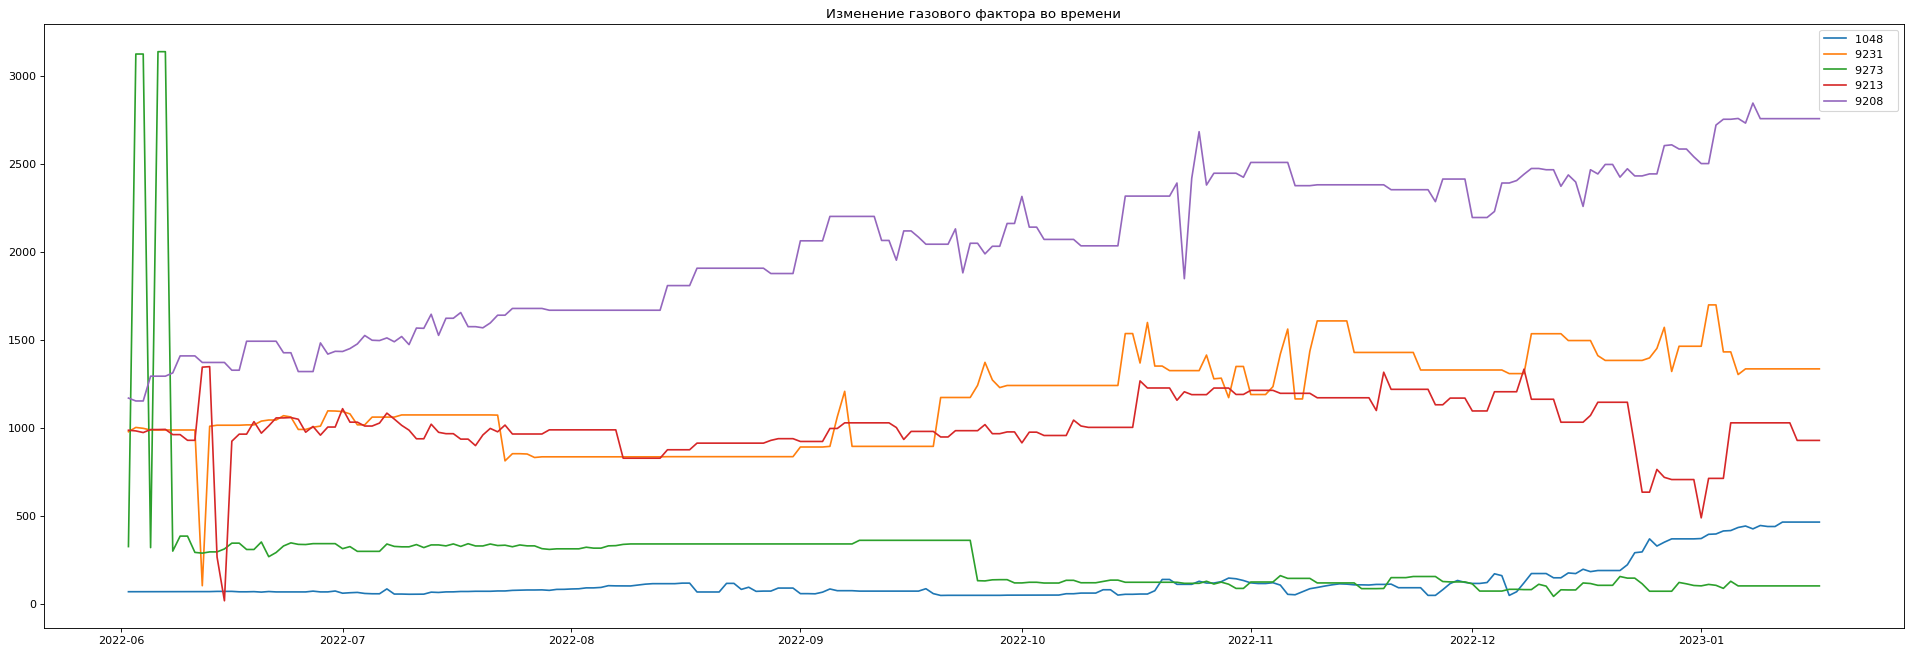

In [44]:
#визуализируем изменение газового фактора во времени для нескольких скважин
plt.figure(figsize=(30, 10), dpi=80);
for well_id in data['well_name'].unique()[35:40]:
    d = data[(data['well_name']==well_id)]
    name = d['well_name'].unique()[0]
    plt.plot(d.index,d['gas_factor'], label=name)
plt.legend()
plt.title('Изменение газового фактора во времени');

Явной закономерности или сезонности визуально не прослеживается.

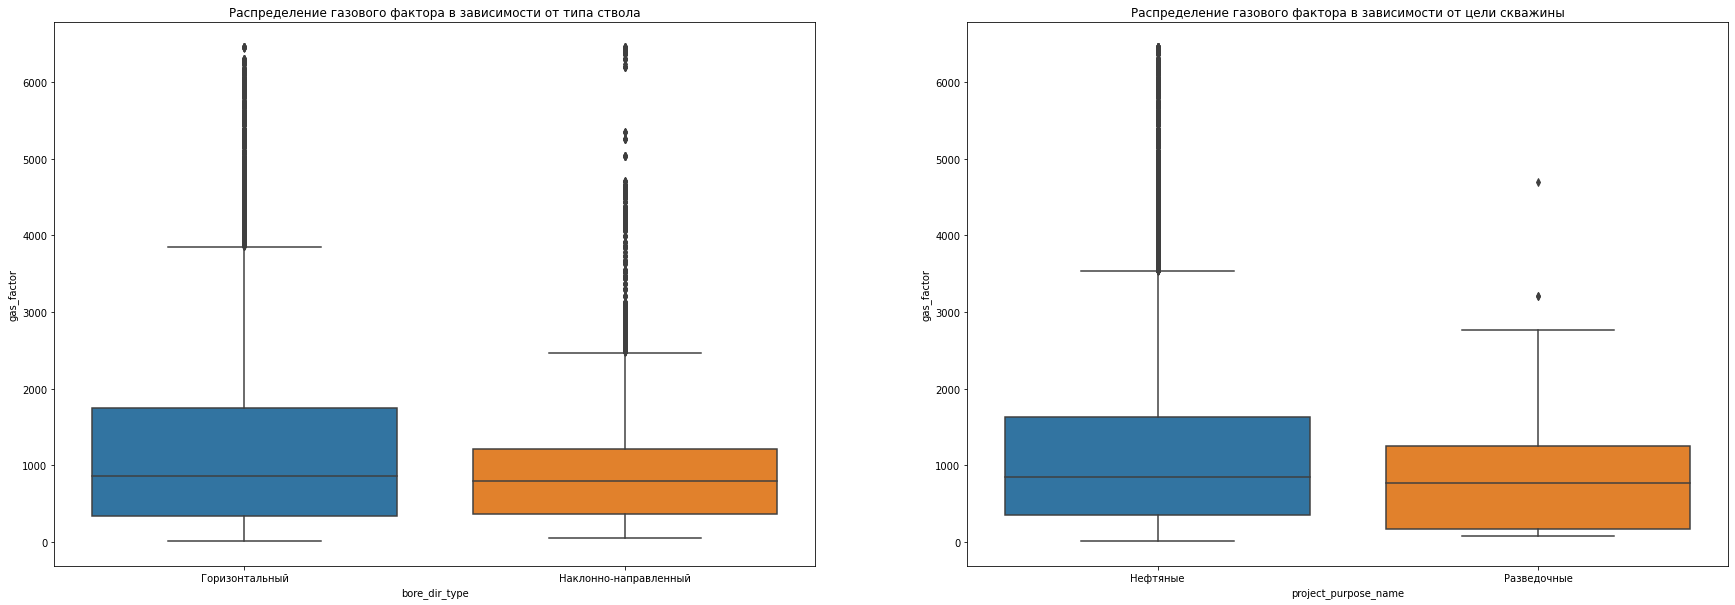

In [45]:
#визуализируем зависимость газового фактора от категориальных переменных
fig, axes = plt.subplots(1, 2, squeeze=False, figsize=(30, 10))
sns.boxplot(y='gas_factor', x='bore_dir_type', data=data, ax=axes[0, 0])
axes[0,0].set_title('Распределение газового фактора в зависимости от типа ствола');
sns.boxplot(y='gas_factor', x='project_purpose_name', data=data, ax=axes[0, 1])
axes[0,1].set_title('Распределение газового фактора в зависимости от цели скважины');

Видимых различий в распределении нет, медианы значений газового фактора находятся примерно на одном уровне.

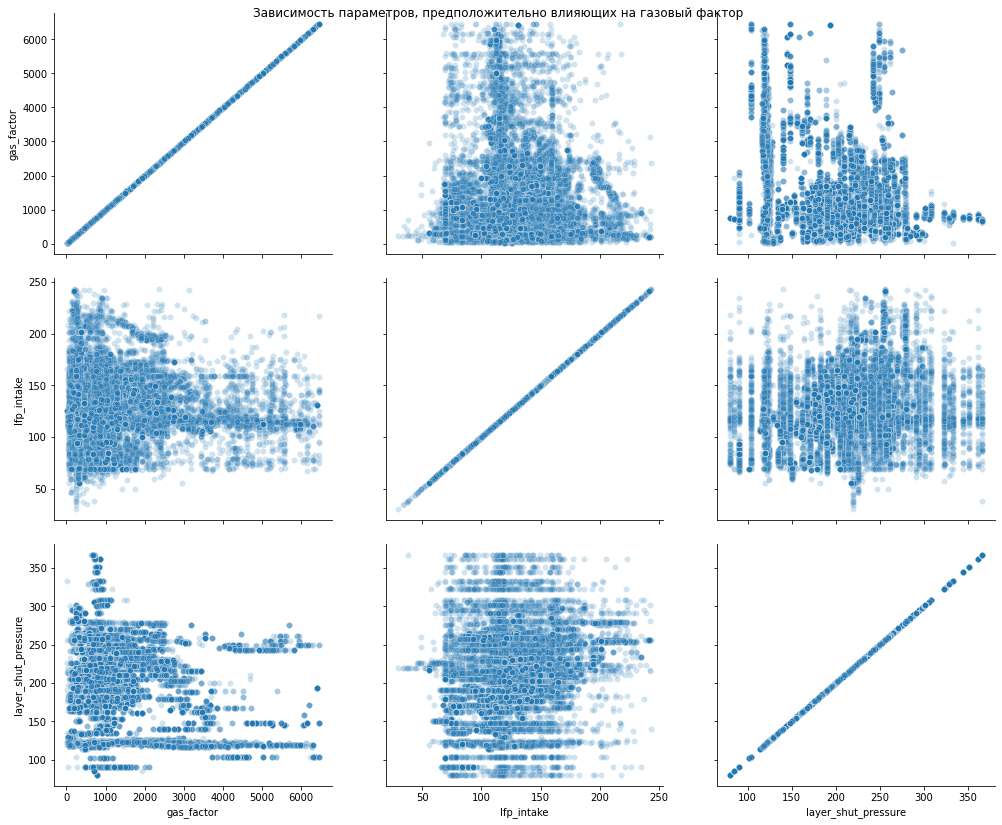

In [46]:
#визуализация попарных зависимостей параметров
ax = sns.PairGrid(data[['gas_factor','lfp_intake','layer_shut_pressure']])
ax.map(sns.scatterplot, alpha=.2)
ax.fig.set_size_inches(15,12)
ax.fig.suptitle('Зависимость параметров, предположительно влияющих на газовый фактор');

Явной зависимости между параметрами не визуализирется.

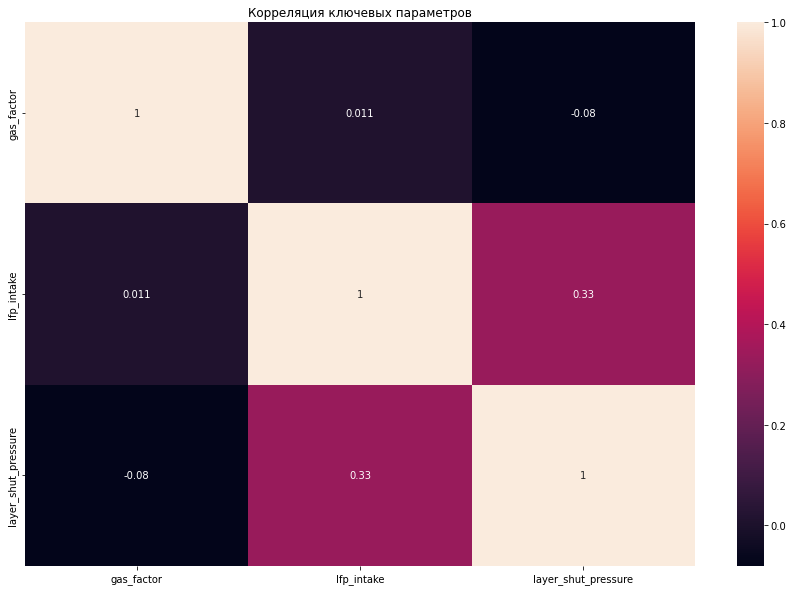

In [47]:
#рассчитаем коэффциенты корреляции и визуализируем в виде тепловой карты
fig, ax = plt.subplots(figsize=(15,10))       
plt.title('Корреляция ключевых параметров');
sns.heatmap(data = data[['gas_factor','lfp_intake','layer_shut_pressure']].corr(), annot=True,ax=ax);

Корреляция газового фактора с забойным давлением: 0.025. Связь очень слабая.  
Корреляция газового фактора с пластовым давлением: -0.12. Связь слабая, нужна дополнительная проверка статистической значимости.

# Масштабирование и разделение данных
Для построения моделей будем использовать все количественные параметры из очищенного датасета.  
Для обучения будем использовать данные всех скважин, кроме одной, данные которой используем в тестовой выборке

In [48]:
#определяем скважину, на которой будем тестировать модель
well=data['well_name'].unique()[random.randint(0, len(data['well_name'].unique())-1)]
idx = data['well_name'] == well

In [49]:
#оставляем только количественные параметры
data_clear = data.copy()
for column in data_clear.columns:
    if(data_clear[column].dtypes in ['datetime64[ns]','object']):
        #print(column)
        data_clear = data_clear.drop(column,axis=1)  

In [50]:
#в тестовую выборку помещаем отдельную скважину, по данным которой модель вообще не обучалась
target = data_clear['gas_factor']
features = data_clear.drop(['gas_factor'],axis=1)

X_train = features[~idx]
X_test = features[idx] 
y_train = target[~idx]
y_test = target[idx]

print(f'train features_size:{X_train.shape}')
print(f'test features_size:{X_test.shape}')
print(f'train target_size:{y_train.shape}')
print(f'test target_size:{y_test.shape}')

train features_size:(26961, 94)
test features_size:(225, 94)
train target_size:(26961,)
test target_size:(225,)


In [51]:
#масштабируем данные
scaler = StandardScaler()
scaler.fit(X_train)
train_scaled = scaler.transform(X_train)
test_scaled = scaler.transform(X_test)

# Модель линейной регрессии

In [52]:
#строим модель и обучаем ее
LR = LinearRegression()
LR.fit(train_scaled,y_train)

LinearRegression()

In [53]:
#получаем предсказание
y_pred = LR.predict(test_scaled)

In [54]:
#собираем вместе предсказания и реальные значения для визуализации
def get_res(y_pred, title):
    results = pd.DataFrame(y_pred,columns=['gas_factor'])
    results['label']='prediction'
    results.reset_index(inplace=True)
    results.columns=['range','gas_factor','label']

    results2 = pd.DataFrame(y_test)
    results2['label']='true'
    results2.reset_index(drop=True,inplace=True)
    results2.reset_index(inplace=True)
    results2.columns=['range','gas_factor','label']

    result = pd.concat([results,results2])
    result = result.sort_values(by='range')
    
    plt.figure(figsize=(30, 10), dpi=80);
    sns.barplot(data=result[:100], x='range', y="gas_factor",hue='label')
    plt.title(f'{title}. Различия предсказанных и истинных значений');
    print(f'RMSE: {mean_squared_error(y_test, y_pred, squared=False)}')

RMSE: 539.0127627990125


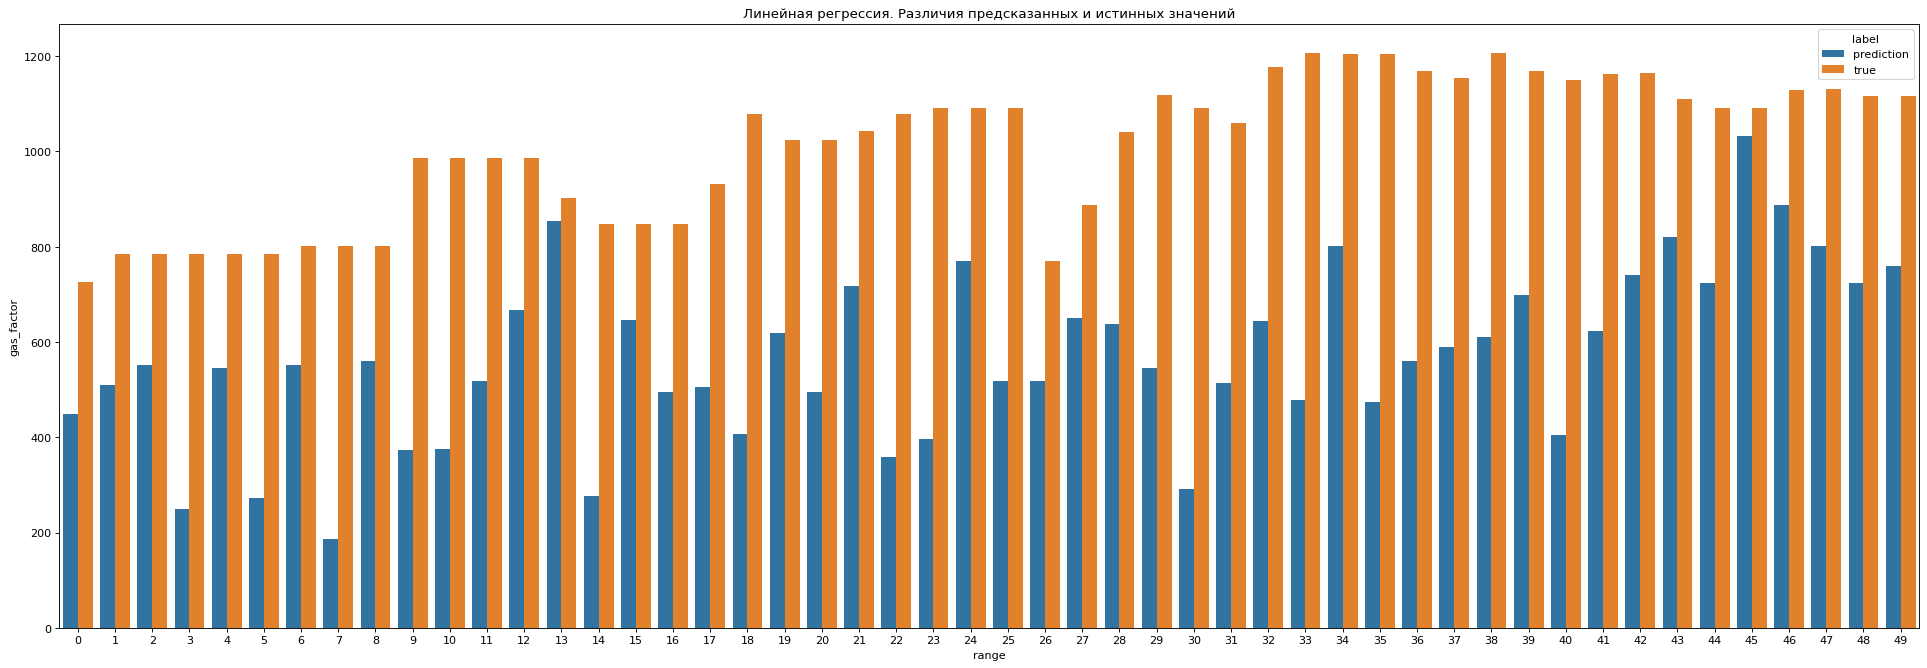

In [55]:
#визуализируем часть предсказаний и рассчитываем ошибку
get_res(y_pred,'Линейная регрессия')

# Решающее дерево

In [56]:
#строим модель и обучаем ее
DT = DecisionTreeRegressor(max_depth=100, splitter='random')
DT.fit(train_scaled,y_train)

DecisionTreeRegressor(max_depth=100, splitter='random')

RMSE: 836.8323607641659


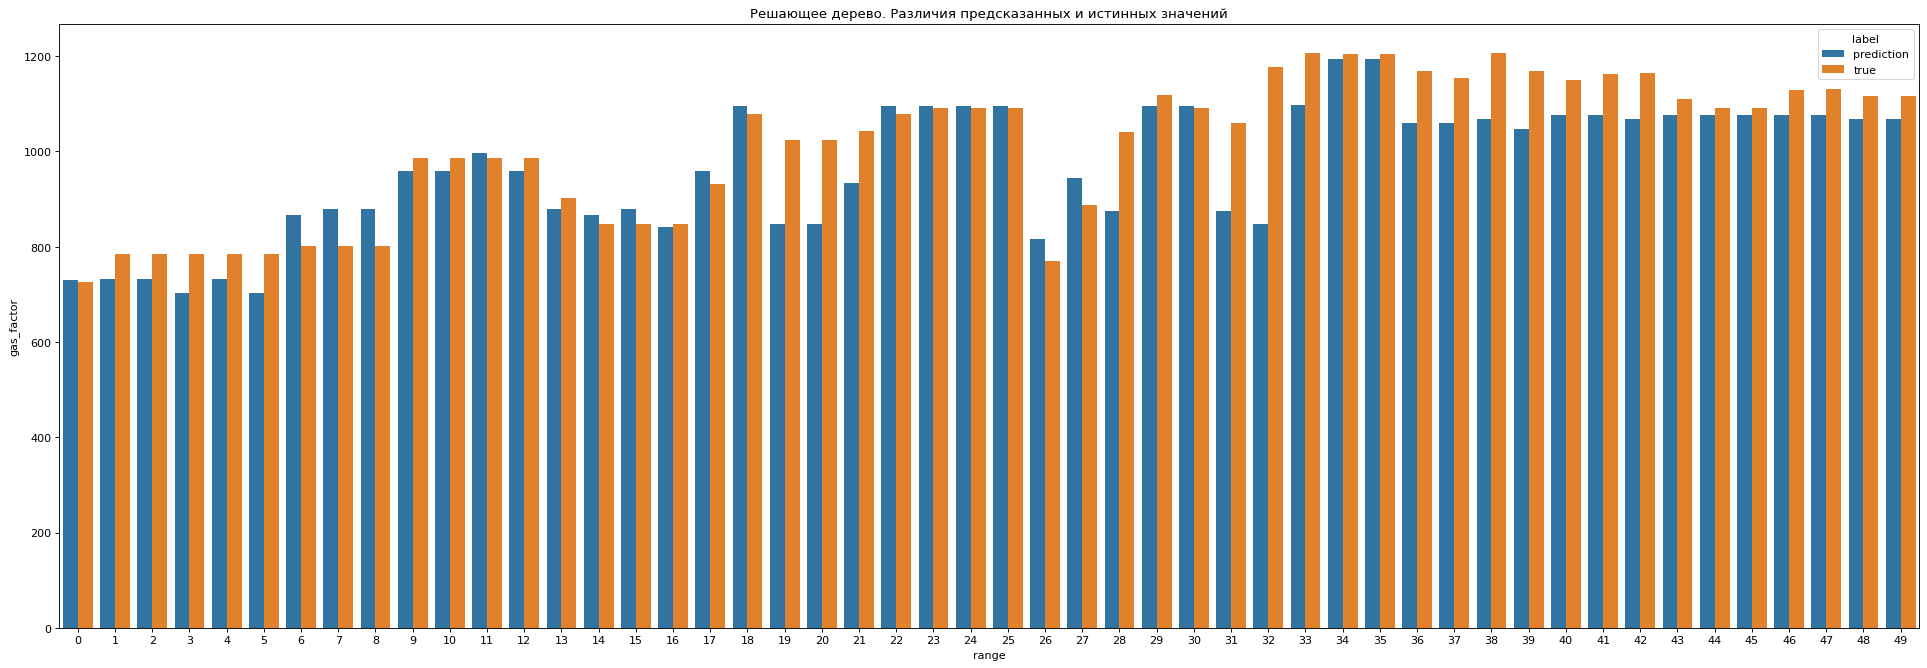

In [57]:
#получаем предсказание
y_pred = DT.predict(test_scaled)
get_res(y_pred, 'Решающее дерево')

# Случайный лес

In [ ]:
#раскомментировать, если хватает ОЗУ
# RF = RandomForestRegressor()
# RF.fit(train_scaled,y_train) 

In [ ]:
# y_pred = RF.predict(test_scaled)
# get_res(y_pred, 'Решающее дерево')

# Вывод
В результате анализа датасета замерной отчетности по скважинам не выявлено взаимосвязи между газовым фактором и забойным/пластовым давлением.  
Разработаны прогнозные модели со следующими метриками RMSE:  
Линейная регрессия: 2482 
Решающее дерево:  
Случайный лес: 